In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import dynesty as dyn
from scipy.special import ndtri
import multiprocessing as mul
from scipy import stats
import pickle
from scipy.integrate import quad
from corner import corner
import pandas as pd
from scipy.stats import gaussian_kde

In [2]:
grbparam = pd.read_csv('GRBPARAM.csv', index_col=0)
# [grbname.replace('.txt','')]

In [3]:
grbname = 'GRB081221.txt'
arr = np.loadtxt(os.getcwd() + '/asciidataof_fig1/32lag/'+grbname)
grbname_wtht_ext = grbname.replace('.txt','')
#Properties of GRB081221
E0 = grbparam[grbname.replace('.txt','')].E0
E0rest = E0
Erest = arr[:,0]    #in keV
z_com = grbparam[grbname.replace('.txt','')].redshift #redshift
nplot = 1000 #burn-in
H0=70 #km/s/Mpc Taken from Sir's Code

data = [arr[:,0], arr[:,1], arr[:,2]]
x = arr[:,0]
y = arr[:,1]
yerr = arr[:,2]

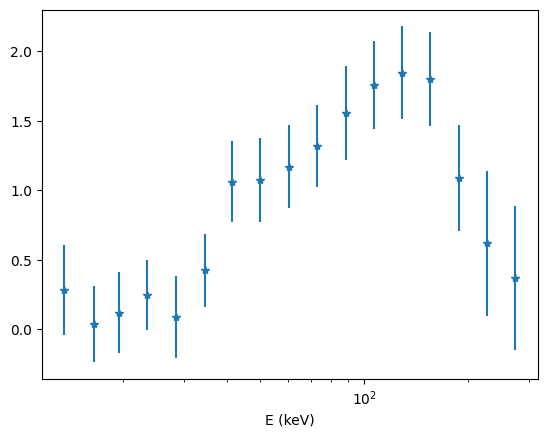

In [4]:
# plt.plot(arr[:,0], arr[:,1], '*')
plt.errorbar(arr[:,0], arr[:,1], yerr=arr[:,2], fmt='*')
plt.xlabel('E (keV)')
plt.xscale('log')
plt.show()

In [5]:
def MODEL_delta_t_intrinsic(E, Eb, alpha1, alpha2, mu, zeta):
    '''
    Broken power law model for lag-energy relation (NULL hypothesis)
    
    Parameters
    ----------
    E : float
        Energy in keV
    Eb : float
        Break energy in keV
    alpha1 : float
        Slope below break/transition energy
    alpha2 : float
        Slope above break/transition energy
    mu : float
        Transition smoothness parameter
    zeta : float
        Normalization constant
    E0 : float
        Energy shift parameter
        
    Returns
    -------
    delta_t : float
        Time lag in seconds
    '''
    E0b = (E - E0)/Eb
    return zeta * (E0b ** alpha1) * (1 + E0b ** ((alpha2 - alpha1)*mu))/2

In [6]:
def loglklhood_null_HP(theta):
    # if E0 in args:
    # x, y, yerr = data
    Eb, alpha1, alpha2, mu, zeta = theta
    model = MODEL_delta_t_intrinsic(x, Eb, alpha1, alpha2, mu, zeta)
    
    # chisq = np.sum(((y-MODEL_delta_t(x, *theta))/yerr)**2)
    # return norm - chisq/2.0
    return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))



In [7]:
def prior_transform(theta):
    Eb, alpha1, alpha2, mu, zeta = theta
    # if E0 in args:
    
   
    return [5000*Eb, -3+13*alpha1, -10+13*alpha2, 3*mu, 4*zeta]

In [8]:
def int_over_red_shift(z, n):
    '''
    Integrate over redshift
    
    Parameters
    ----------
    z : float
        Redshift
    n : float
        LIV Polynomial power        
    '''
    
    
    #    f = lambda x: ((1+x)**n)/h_gp(x)
    f = lambda x: ((1+x)**n)/np.sqrt(0.3*(1+x)**3 + 0.7)
    return quad(f, 0, z)[0]


K_z1 = int_over_red_shift(z_com,1)
K_z2 = int_over_red_shift(z_com,2)
	
def linear(E, z, E_qg, Eb, alpha1, alpha2, mu, zeta):
    K_z= np.asarray(K_z1)
    # return (1+z)*tau*(Erest - E0rest) + (-(10**14)/(H0*3.24))*((Erest - E0rest)*K_z/(E_qg*(1+z)))
    return MODEL_delta_t_intrinsic(E, Eb, alpha1, alpha2, mu, zeta) + (-(10**14)/(H0*3.24))*((E - E0)*K_z/(E_qg*(1+z)))

def quadratic(E, z, E_qg, Eb, alpha1, alpha2, mu, zeta):
    E_0=E0rest/(1+z)
    Eres=E/(1+z)
    K_z = np.asarray(K_z2)
    # return (1+z)*tau*(Erest**2 - E0rest**2) + (-1.5*(10**8)/(H0*3.24))*((E**2 - E_0**2)*K_z/E_qg**2)
    return MODEL_delta_t_intrinsic(E, Eb, alpha1, alpha2, mu, zeta) + (-1.5*(10**8)/(H0*3.24))*((Eres**2 - E_0**2)*K_z/E_qg**2)



def loglklhood_LIV_lin(theta1):
    
    E_qg, Eb, alpha1, alpha2, mu, zeta = theta1
    
    model = linear(x, z_com, E_qg, Eb, alpha1, alpha2, mu, zeta)
    
    return sum(stats.norm.logpdf(*rgs) for rgs in zip(y,model,yerr))


def loglklhood_LIV_quad(theta2):
    
    E_qg, Eb, alpha1, alpha2, mu, zeta = theta2
    
    model = linear(x, z_com, E_qg, Eb, alpha1, alpha2, mu, zeta)
    
    return sum(stats.norm.logpdf(*rgs) for rgs in zip(y,model,yerr))
    
    
    
def prior_transform_LIV_lin(theta1):
    E_qg, Eb, alpha1, alpha2, mu, zeta = theta1
    return [1e20*E_qg, 5000*Eb, -3+13*alpha1, -10+13*alpha2, 3*mu, 4*zeta]

def prior_transform_LIV_quad(theta2):
    E_qg, Eb, alpha1, alpha2, mu, zeta = theta2
    return [1e15*E_qg, 5000*Eb, -3+13*alpha1, -10+13*alpha2, 3*mu, 4*zeta]



In [9]:
nlive = 1024
ndim_NULL = 5
ndim_LIV = 6

# NULL hypothesis

with dyn.pool.Pool(12, loglklhood_null_HP, prior_transform) as Pool:
    sampler0 = dyn.NestedSampler(loglklhood_null_HP, prior_transform, ndim=ndim_NULL, bound='multi', sample='rwalk', pool=Pool, nlive=nlive)
    sampler0.run_nested( dlogz=0.1)
    results0 = sampler0.results
    
Pool.close()
print(results0.summary())



with open(os.getcwd() + f'/pickle/{grbname_wtht_ext}_results_null.pkl', 'wb') as f:
    pickle.dump(results0, f)

with open(os.getcwd() + f'/pickle/{grbname_wtht_ext}_sampler_null.pkl', 'wb') as f:
    pickle.dump(sampler0, f)

11984it [01:26, 138.91it/s, +1024 | bound: 56 | nc: 1 | ncall: 246288 | eff(%):  5.304 | loglstar:   -inf < -13.467 <    inf | logz: -22.829 +/-    nan | dlogz:  0.000 >  0.100]


Summary
nlive: 1024
niter: 11984
ncall: 245264
eff(%):  5.304
logz: -22.829 +/-  0.111
None


In [10]:
# Linear LIV
with dyn.pool.Pool(12, loglklhood_LIV_lin, prior_transform_LIV_lin) as Pool:
    sampler1 = dyn.NestedSampler(loglklhood_LIV_lin, prior_transform_LIV_lin, ndim=ndim_LIV, bound='multi', sample='rwalk', pool=Pool, nlive=nlive)
    sampler1.run_nested( dlogz=0.1)
    results1 = sampler1.results

Pool.close()
print(results1.summary())


with open(os.getcwd() + f'/pickle/{grbname_wtht_ext}_results_LIV_lin.pkl', 'wb') as f:
    pickle.dump(results1, f)

with open(os.getcwd() + f'/pickle/{grbname_wtht_ext}_sampler_LIV_lin.pkl', 'wb') as f:
    pickle.dump(sampler1, f)

11891it [00:59, 201.42it/s, +1024 | bound: 59 | nc: 1 | ncall: 252458 | eff(%):  5.137 | loglstar:   -inf < -13.467 <    inf | logz: -22.738 +/-    nan | dlogz:  0.000 >  0.100]


Summary
nlive: 1024
niter: 11891
ncall: 251434
eff(%):  5.137
logz: -22.738 +/-  0.111
None


In [11]:
# Quadratic LIV
with dyn.pool.Pool(12, loglklhood_LIV_quad, prior_transform_LIV_quad) as Pool:
    sampler2 = dyn.NestedSampler(loglklhood_LIV_quad, prior_transform_LIV_quad, ndim=ndim_LIV, bound='multi', sample='rwalk', pool=Pool, nlive=nlive)
    sampler2.run_nested( dlogz=0.1)
    results2 = sampler2.results
    
Pool.close()
print(results2.summary())

with open(os.getcwd() + f'/pickle/{grbname_wtht_ext}_results_LIV_quad.pkl', 'wb') as f:
    pickle.dump(results2, f)
    

with open(os.getcwd() + f'/pickle/{grbname_wtht_ext}_sampler_LIV_quad.pkl', 'wb') as f:
    pickle.dump(sampler2, f)

13899it [00:56, 245.45it/s, +1024 | bound: 72 | nc: 1 | ncall: 306288 | eff(%):  4.889 | loglstar:   -inf < -11.672 <    inf | logz: -22.960 +/-    nan | dlogz:  0.000 >  0.100] 


Summary
nlive: 1024
niter: 13899
ncall: 305264
eff(%):  4.889
logz: -22.960 +/-  0.104
None


In [12]:
# def plotsamples(results, figname='corner', labels=["E_qg", "Eb", "alpha1", "alpha2", "mu", "zeta"]):
#     weights = np.exp(results.logwt - results.logz[-1])
#     samples = dyn.utils.resample_equal(  results.samples, weights)
#     corner(samples, weights=weights, labels=labels, levels=[0.68, 0.9], show_titles=True, title_kwargs={"fontsize": 12})
#     plt.savefig(os.getcwd() + '/outputs/' + figname + '.png')
#     plt.show()

In [13]:
def smooth_plot(results, figname, labels=["E_qg", "Eb", "alpha1", "alpha2", "mu", "zeta"]):
    weights = np.exp(results.logwt - results.logz[-1])
    samples = dyn.utils.resample_equal(  results.samples, weights)
    
    fig = corner(samples, weights=weights, labels=labels, levels=[0.68, 0.9], show_titles=True, title_kwargs={"fontsize": 12}, hist_kwargs={'density': True})
    ndim =samples.shape[1]
    for axidx, samps in zip([i*(ndim+1) for i in range(ndim)],samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')
    plt.savefig(os.getcwd() + '/outputs/' + figname + '.png')
    plt.show()

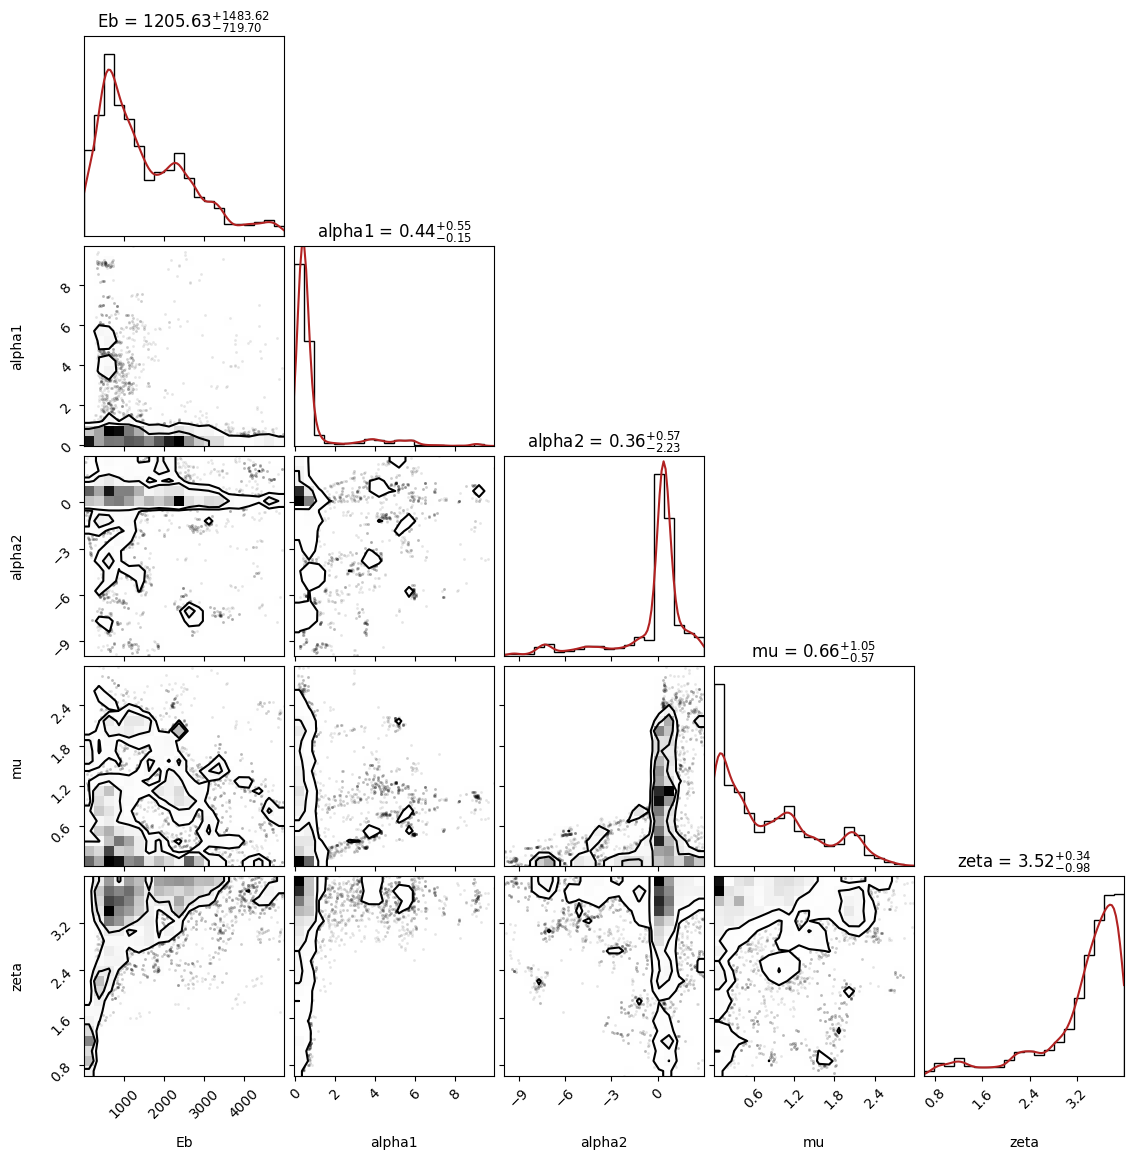

In [14]:
smooth_plot(results0, figname=grbname_wtht_ext + 'null_HP', labels=["Eb", "alpha1", "alpha2", "mu", "zeta"])

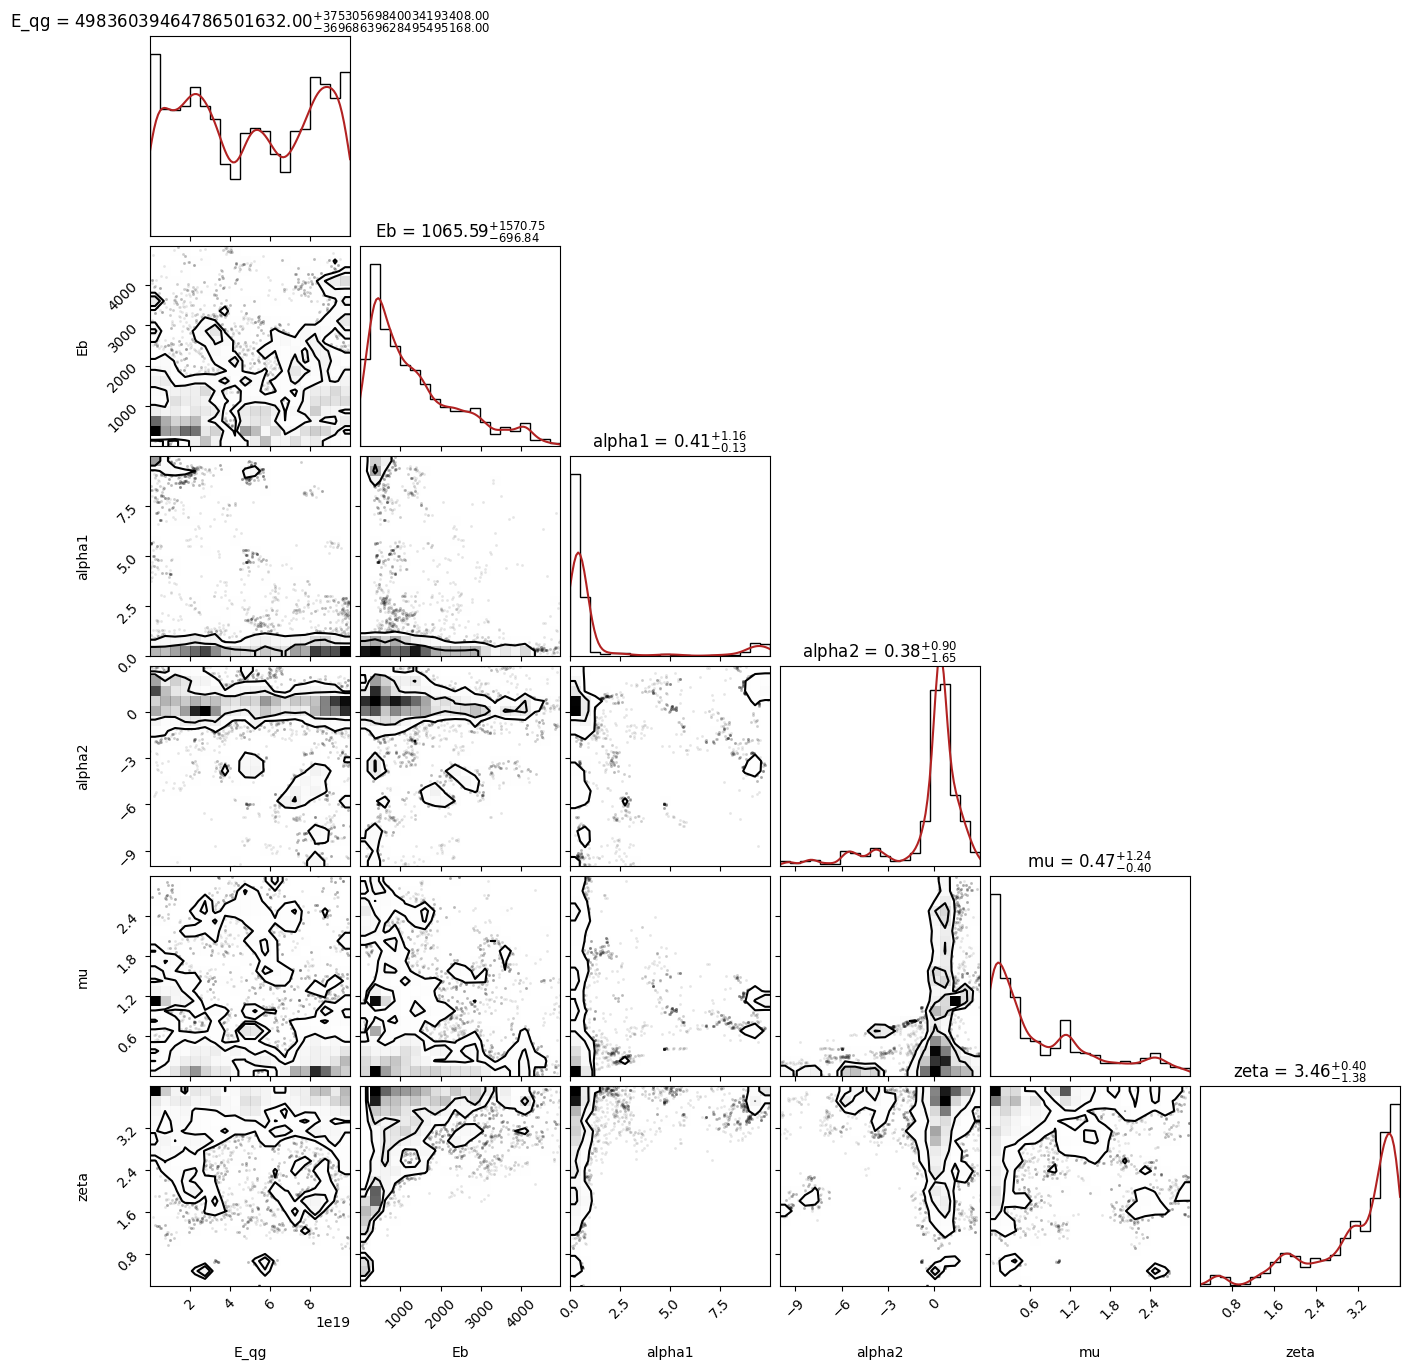

In [15]:
smooth_plot(results1, figname=grbname_wtht_ext + 'LIV_lin' + '_smooth')

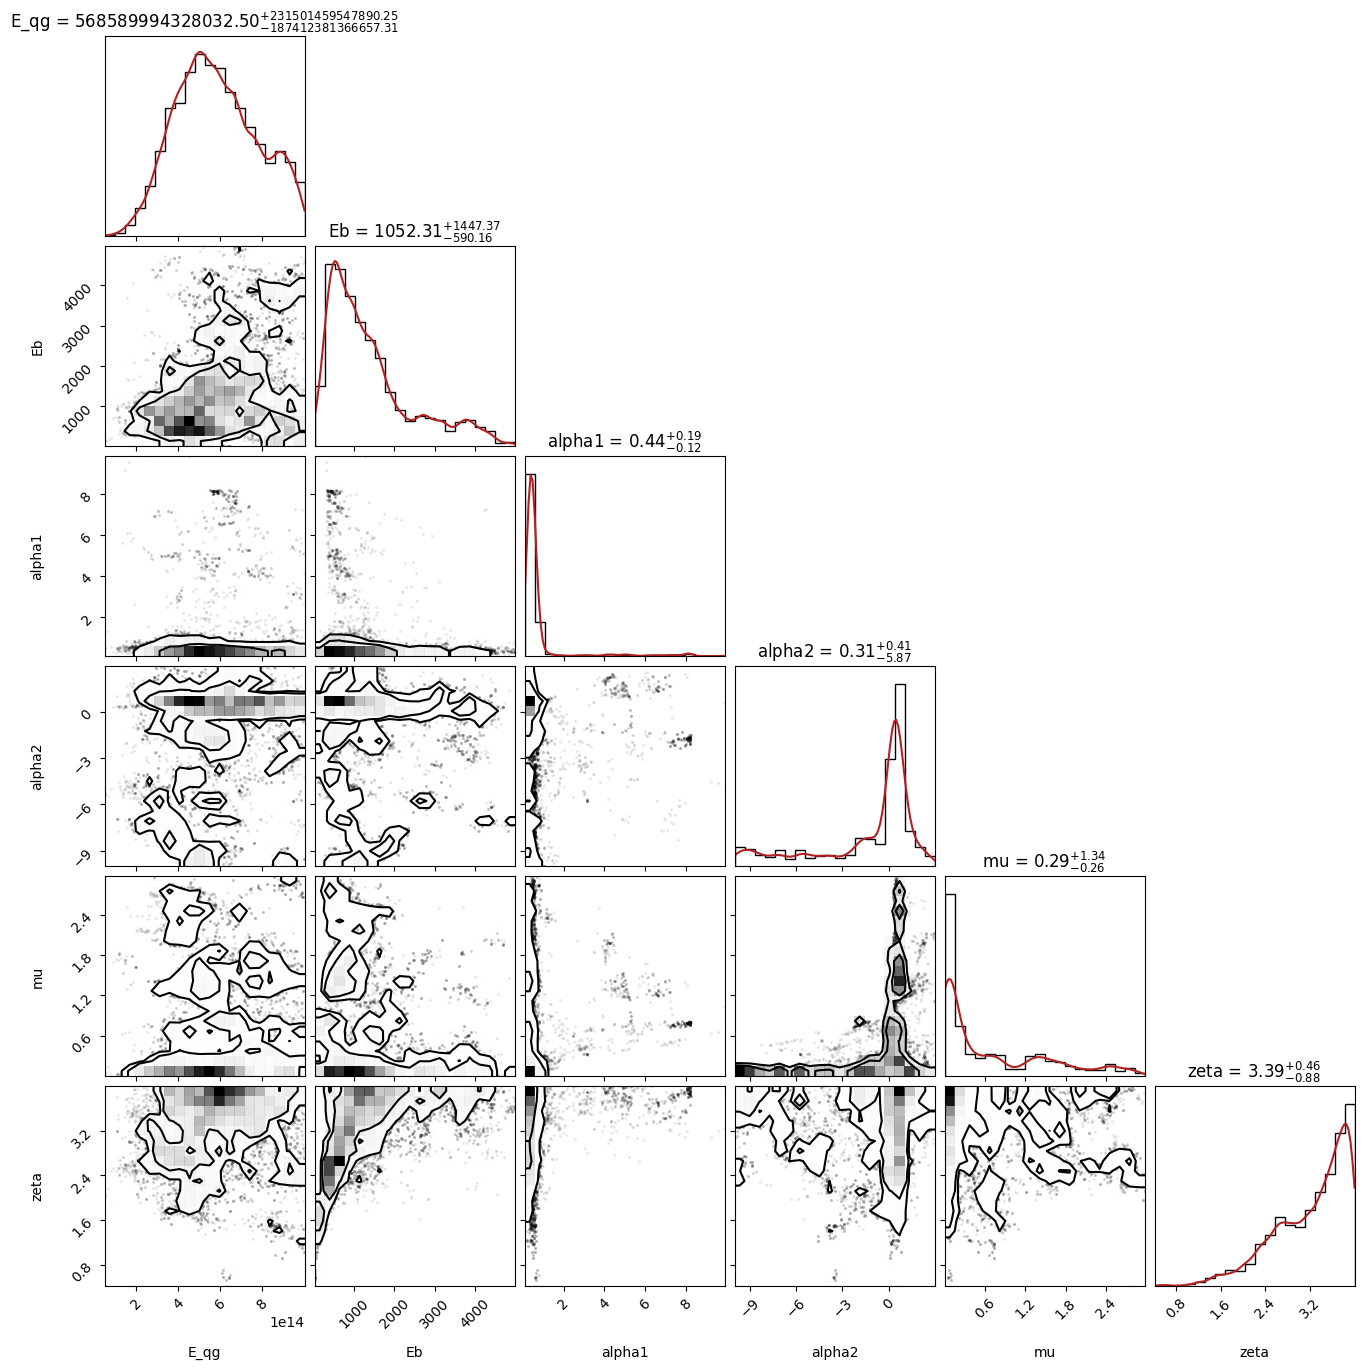

In [16]:
smooth_plot(results2, figname=grbname_wtht_ext + 'LIV_quad' + '_smooth')

In [18]:
# Eb, alpha1, alpha2, mu, zeta = theta2
E = np.linspace(min(Erest), max(Erest), nplot)
samples0 = dyn.utils.resample_equal( results0.samples, np.exp(results0.logwt - results0.logz[-1]))
samples0 = np.median(samples0, axis=0)

samples1 = dyn.utils.resample_equal( results1.samples, np.exp(results1.logwt - results1.logz[-1]))
samples1 = np.median(samples1, axis=0)

samples2 = dyn.utils.resample_equal( results2.samples, np.exp(results2.logwt - results2.logz[-1]))
samples2 = np.median(samples2, axis=0)

null_fit = [MODEL_delta_t_intrinsic(E[i], samples0[0], samples0[1], samples0[2], samples0[3], samples0[4]) for i in range(nplot)]
liv_lin_fit = [linear(E[i], z_com, samples1[0], samples1[1], samples1[2], samples1[3], samples1[4], samples1[5]) for i in range(nplot)]
liv_quad_fit = [quadratic(E[i], z_com, samples1[0], samples1[1], samples1[2], samples1[3], samples1[4], samples1[5]) for i in range(nplot)]

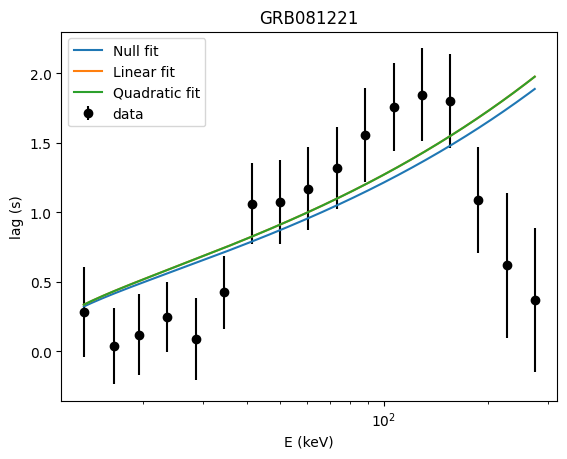

In [19]:
plt.errorbar(Erest, y, yerr, fmt='o', color='black', label='data')
plt.plot(E, null_fit[:], label='Null fit')
plt.plot(E, liv_lin_fit,label='Linear fit')
plt.plot(E, liv_quad_fit, label='Quadratic fit')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.xlabel('E (keV)')
plt.ylabel('lag (s)')
plt.title(grbname_wtht_ext)
plt.savefig(os.getcwd() + '/outputs/' + grbname_wtht_ext + '_fit.png', facecolor='white')
plt.show()

In [21]:
bayes_factor_lin = np.exp(results1.logz[-1] - results0.logz[-1])
bayes_factor_quad = np.exp(results2.logz[-1] - results0.logz[-1])

print('Bayes factor for linear LIV model: ', bayes_factor_lin)
print('Bayes factor for quadratic LIV model: ', bayes_factor_quad)

Bayes factor for linear LIV model:  1.0944446264786578
Bayes factor for quadratic LIV model:  0.8770789572961529
